# MLFlow Demo

In [13]:
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'password'
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'
endpoint = 'http://localhost:9000'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = endpoint

In [20]:
# check if 
import boto3

from botocore.client import Config

bucket_name = 'mlflow' 
s3 = boto3.resource('s3', endpoint_url=endpoint)
if s3.Bucket(bucket_name) not in s3.buckets.all():
    s3.create_bucket(Bucket=bucket_name)

## Simple log with image

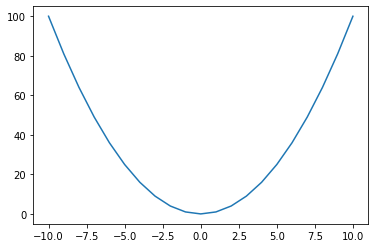

In [21]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment('my-experiment')

with mlflow.start_run():
    # log a parameter
    mlflow.log_param('my-param', 16)
    mlflow.set_tag('tag', 'mytag')
    # log several metrics
    for i in range(0,5):
        mlflow.log_metric('metric', i*2, step=i)
        mlflow.log_metric('metric_squared', i*i, step=i)

    # log a figure
    fig, ax = plt.subplots()
    x=np.array(range(-10,11))
    subfig = sns.lineplot(x=x,y=x*x) 
    mlflow.log_figure(fig, "myfigure.png")



## Log Scikit learn model

- Autolog scikit learn
- Log models


In [22]:
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [23]:
experiment_id = mlflow.set_experiment('lfr-demo-model')
with mlflow.start_run():
    iris = datasets.load_iris()
    iris_train = pd.DataFrame(iris.data, columns=iris.feature_names)
    mlflow.sklearn.autolog() 
    clf = RandomForestClassifier(max_depth=7, random_state=0)
    clf.fit(iris_train, iris.target)
    signature = infer_signature(iris_train, clf.predict(iris_train))
    mlflow.sklearn.log_model(clf, "iris_rf", signature=signature)

INFO: 'lfr-demo-model' does not exist. Creating a new experiment


## Nested runs

In [27]:
experiment_id = mlflow.set_experiment('nested')
with mlflow.start_run(run_name='Parent') as parent_run:
    results = []
    for i in range(4):
        with mlflow.start_run(run_name=f"Child {i}", nested=True):
            mlflow.log_param("Factor", i)
            result = i*i
            mlflow.log_metric("Result", result)
            results.append(result)
        mlflow.log_metric("Result", result, i)
        
    mlflow.log_metric("max", max(results))